# Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # used for the legend at step duration
import seaborn as sns
import numpy as np
import datetime
import scipy.stats as st
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

from functions import cleaning 

In [2]:
# Disabling a specific type of warning from Jupyter, that I know if mistaken for something else
pd.options.mode.chained_assignment = None 

# Loading dataset

In [3]:
filepath1 = '../Data/df_final_demo.txt' # Client Profiles
filepath2 = '../Data/df_final_web_data_pt_1.txt' # Digital Footprints, part 1
filepath3 = '../Data/df_final_web_data_pt_2.txt' # Digital Footprints, part 2
filepath4 = '../Data/df_final_experiment_clients.txt' # Experiment Roster 

# Loading datasets
df_clients = pd.read_csv(filepath1)
df2 = pd.read_csv(filepath2)
df3 = pd.read_csv(filepath3)
df_roster = pd.read_csv(filepath4)

# Merging part 1 and 2 of Digital Footprints
df_trace = pd.concat([df2, df3], axis=0, ignore_index=True)

# Data cleaning

In [4]:
df_clients, df_trace, df_roster, df_clients_with_na = cleaning(df_clients, df_trace, df_roster)

# Client profile and behaviour analysis

#### Clients' age

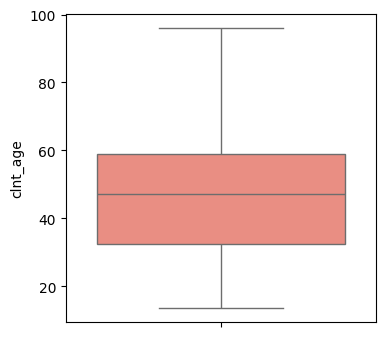

In [5]:
# Box plot with client's age
plt.figure(figsize=(4, 4))
sns.boxplot(data=df_clients['clnt_age'], color='salmon')
plt.show()

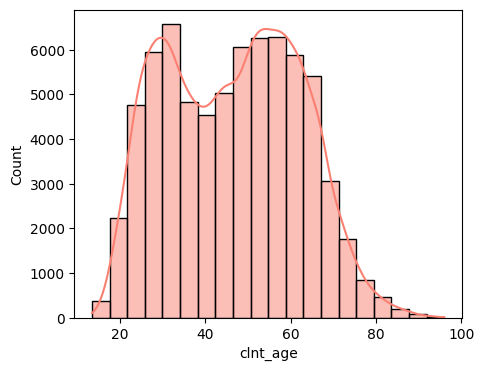

In [6]:
# Histogram with client's age
plt.figure(figsize=(5, 4))
sns.histplot(df_clients['clnt_age'], kde=True, bins=20, color='salmon')
plt.show()

We observe from the boxplot that the clients' age doesn't have outliers.

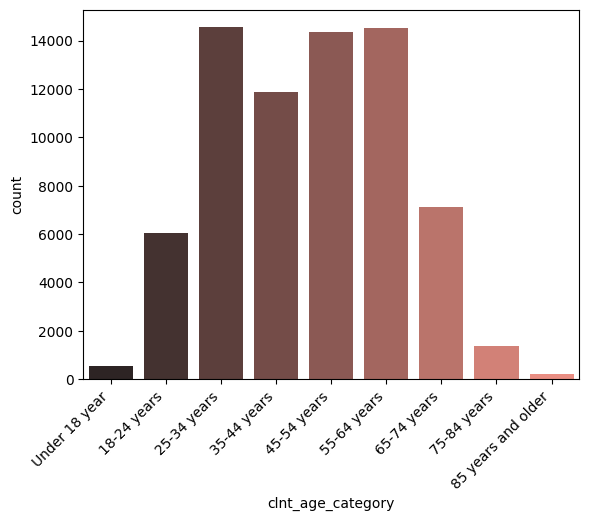

In [7]:
# I want to check the above with some age brackets
bins = [0, 18.0, 25.0, 35.0, 45.0, 55.0, 65.0 , 75.0, 85.0, df_clients['clnt_age'].max()]
labels = ['Under 18 year', '18-24 years', '25-34 years', '35-44 years', '45-54 years', 
          '55-64 years', '65-74 years', '75-84 years', '85 years and older']

df_clients['clnt_age_category'] = pd.cut(df_clients['clnt_age'], bins=bins, labels=labels, include_lowest=True)


# Making a countplot
sns.countplot(data=df_clients, x='clnt_age_category', palette='dark:salmon', hue='clnt_age_category', legend=False)
plt.xticks(rotation=45, ha='right')
plt.show()

It's notable that the clients predominantly fall into two age groups: 25-34 years and 45-64 years. Moreover, the interquartile range (IQR) reinforces this observation, spanning from 32 to 59 years, indicating that the majority of clients are concentrated within this age range.

#### Clients' tenure years

<Axes: xlabel='clnt_tenure_yr', ylabel='Count'>

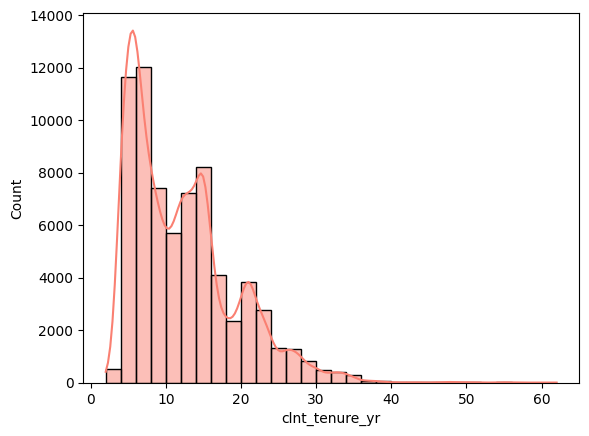

In [8]:
# Histogram with client's tenure years
sns.histplot(df_clients['clnt_tenure_yr'], kde=True, bins=30, color='salmon')

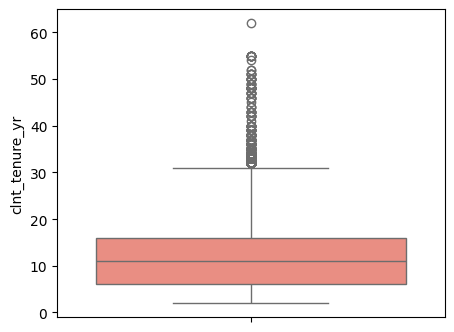

In [9]:
# Box plot with client's tenure years
plt.figure(figsize=(5, 4))
sns.boxplot(data=df_clients['clnt_tenure_yr'], color='salmon')
plt.show()

The distribution of client tenure years is right skewed, and appears to have outliers with higher values. Although outliers are present, in the analysis they will be considered normal, since in the context of an investment management company there can be as long-term clients. The majority of clients have tenures ranging from approximately 6 to 16 years, as indicated by the interquartile range (IQR).

#### Client's gender

Based on the initial exploration, there appears to be a relatively balanced distribution between male and female clients.

#### Interaction with company via call/ platform visit

The vast majority of the clients had some interaction with the company via call or platform visit the last 6 months.

From the intial exploration, with the Pearson correlation analysis, it appears that the most notable linear relationship exists between the number of logins to the site and the number of calls made by the customer within the last 6 months. The Spearman correlation analysis similarly indicates that the strongest association is observed between the number of logins and the number of calls made by customers in the last 6 months, and doesn't reveal any other strong correlation.

# Sample analysis: average time between successful steps

### The distribution of times spent in each step

In [10]:
# Specify the number of users for sample testing
num_users_to_select = 10000

# Select a random sample of users from the client dataframe
sample_users = df_clients['client_id'].sample(n=num_users_to_select, random_state=42)  # Random_state can be adjusted for reproducibility


# Filter the DataFrame to include only the selected users
sample_df = df_trace[df_trace['client_id'].isin(sample_users)]


# Changing step names, sorting dataframe and resseting index, to help with the analysis below
sample_df['process_step'] = sample_df['process_step'].map({'start':1,'step_1':2,'step_2':3,'step_3':4,'confirm':5})
sample_df.sort_values(by=['visit_id','date_time'], ascending=False, inplace=True)
sample_df = sample_df.reset_index(drop=True)

# Adding new columns with previous visit_id, previous process step and previous time, to help with the analysis below
sample_df['previous_visit_id'] = sample_df['visit_id'].shift(-1, fill_value=0)
sample_df['previous_process_step'] = -1
sample_df['previous_date_time'] = '1970-01-01 00:00:00'


# Iterating over each row in the dataframe and checking if the 'visit_id' matches the 'previous_visit_id' in the subsequent row
# If they match, updating the 'previous_process_step' and 'previous_date_time' of the current row with the values from the subsequent row
len_df = sample_df.shape[0]
for i in range(len_df):
    if sample_df.loc[i,'visit_id'] == sample_df.loc[i,'previous_visit_id']:
        sample_df.loc[i,'previous_process_step'] = sample_df.loc[i+1,'process_step']
        sample_df.loc[i,'previous_date_time'] = sample_df.loc[i+1,'date_time']


# Converting to datetime
sample_df['date_time'] = pd.to_datetime(sample_df['date_time'],format='%Y-%m-%d %H:%M:%S')
sample_df['previous_date_time'] = pd.to_datetime(sample_df['previous_date_time'],format='%Y-%m-%d %H:%M:%S')


# Adding a new layer, to check how the current step and the previous step compare
sample_df['subtracting_step'] = sample_df['process_step'] - sample_df['previous_process_step']

# Adding a new layer, to find the time between successful steps, and filter out the ones with no useful info
sample_df['subtracting_date_time'] = sample_df['date_time'] - sample_df['previous_date_time']


# Filtering the sample, to the interactions that moved one step forward == 1
# and excluding the ones that had substraction with the placeholder date '1970-01-01 00:00:00' < 10000 days
filtered_sample_df = sample_df[(sample_df['subtracting_step'] == 1) & (sample_df['subtracting_date_time'] < '10000 days 00:00:00')]

In [11]:
filtered_sample_df['subtracting_date_time'].describe()

count                        37434
mean     0 days 00:01:01.912672971
std      0 days 00:01:40.008641670
min                0 days 00:00:00
25%                0 days 00:00:12
50%                0 days 00:00:32
75%                0 days 00:01:11
max                0 days 00:41:44
Name: subtracting_date_time, dtype: object

In [12]:
filtered_sample_df['subtracting_date_time'].quantile(0.95) #  3 minutes at the 95% percentile

Timedelta('0 days 00:03:29')

#### Defining outliers with IQR method

In [13]:
IQR = filtered_sample_df['subtracting_date_time'].quantile(0.75) - filtered_sample_df['subtracting_date_time'].quantile(0.25)
upper_limit_for_outliers = filtered_sample_df['subtracting_date_time'].quantile(0.75) + IQR
upper_limit_for_outliers

Timedelta('0 days 00:02:10')

#### Defining outliers with Standard Deviation method

In [14]:
filtered_sample_df['subtracting_date_time'].mean() + filtered_sample_df['subtracting_date_time'].std()*3

Timedelta('0 days 00:06:01.938597981')

By this sample analysis, it appears that the average duration for a step forward in the online interaction is approximately 2 minutes, with the majority of the observations(95% percentile) within a range of around 3,5 minutes. **To identify outliers, I utilized statistical methods, opting for the Standard Deviation method (multpiplied by 3)**, which indicates that **anything exceeding 6 minutes and 2 seconds should be considered an outlier**.  

I will incorporate the identified duration as a threshold to distinguish between sessions in digital footstep analysis. Considering typical intervals between steps of less than the threshold will help determine continuity within sessions versus potential new sessions.

# Digital footprints - defining sessions: completed or not, valid/invalid

### Two dataframes for 'test' and 'control' group

In [15]:
# Creating two dataframes for the two groups of the test
df_roster_test = df_roster[df_roster.variation == 'Test']
df_roster_control = df_roster[df_roster.variation == 'Control']


# Filtering 
df_test = df_trace[df_trace.client_id.isin(df_roster_test.client_id.unique().tolist())]
df_control = df_trace[df_trace.client_id.isin(df_roster_control.client_id.unique().tolist())]


# Rename column for brevity
df_test = df_test.rename(columns={'process_step': 'step'})
df_control = df_control.rename(columns={'process_step': 'step'})


# Replacing the step names with numbers for analysis purposes, will do subtraction later
df_test['step']  = df_test['step'] .map({'start':1,'step_1':2,'step_2':3,'step_3':4,'confirm':5})
df_control['step']  = df_control['step'] .map({'start':1,'step_1':2,'step_2':3,'step_3':4,'confirm':5})


# Sorting dataframes
df_test.sort_values(by=['client_id','date_time'], ascending=False, inplace=True)
df_control.sort_values(by=['client_id','date_time'], ascending=False, inplace=True)


# Dropping the columns that are not needed for the scope of this sample analysis
df_test.drop(columns=['visitor_id','visit_id'], inplace=True)
df_control.drop(columns=['visitor_id','visit_id'], inplace=True)


# Resetting index
df_test = df_test.reset_index(drop=True)
df_control = df_control.reset_index(drop=True)

### New columns for analysis

In [16]:
# Adding new columns that I will use for comparison: previous  and next client_id
df_test['prev_id'] = df_test['client_id'].shift(-1, fill_value=0)
df_control['prev_id'] = df_control['client_id'].shift(-1, fill_value=0)

df_test['next_id'] = df_test['client_id'].shift(1, fill_value=0)
df_control['next_id'] = df_control['client_id'].shift(1, fill_value=0)


# Adding new columns that I will use for comparison: previous and next step
df_test['prev_step'] = df_test['step'].shift(-1, fill_value=0)
df_control['prev_step'] = df_control['step'].shift(-1, fill_value=0)

df_test['next_step'] = df_test['step'].shift(1, fill_value=0)
df_control['next_step'] = df_control['step'].shift(1, fill_value=0)


# Adding new columns that I will use for comparison: previous datetime, next datetime
df_test['prev_time'] = df_test['date_time'].shift(-1, fill_value='1970-01-01 00:00:00')
df_control['prev_time'] = df_control['date_time'].shift(-1, fill_value='1970-01-01 00:00:00')

df_test['prev_time'] = pd.to_datetime(df_test['prev_time'],format='%Y-%m-%d %H:%M:%S')
df_control['prev_time'] = pd.to_datetime(df_control['prev_time'],format='%Y-%m-%d %H:%M:%S')

df_test['next_time'] = df_test['date_time'].shift(1, fill_value='1970-01-01 00:00:00')
df_control['next_time'] = df_control['date_time'].shift(1, fill_value='1970-01-01 00:00:00')

df_test['next_time'] = pd.to_datetime(df_test['next_time'],format='%Y-%m-%d %H:%M:%S')
df_control['next_time'] = pd.to_datetime(df_control['next_time'],format='%Y-%m-%d %H:%M:%S')


# Adding new columns that I will use for comparison: time difference between current and last step
df_test['time_diff_prev'] = df_test['date_time'] - df_test['prev_time']
df_control['time_diff_prev'] = df_control['date_time'] - df_control['prev_time']


# Adding new columns that I will use for comparison: step duration (difference of following datime with current one)
df_test['time_diff_next'] = df_test['next_time'] - df_test['date_time']
df_control['time_diff_next'] = df_control['next_time'] - df_control['date_time']


# Adding a new layer, to count the steps back, but making sure that I don't compare different clients
df_test['subtract_step'] = np.where(df_test['client_id'] == df_test['prev_id'], 
                                          (df_test['step'] - df_test['prev_step']),0)
df_control['subtract_step'] = np.where(df_control['client_id'] == df_control['prev_id'], 
                                          (df_control['step'] - df_control['prev_step']),0)

### Defining seperate sessions

Conditions:

The conditions aim to identify the start of a new session within a sequence of actions. **If the current action is the first step ('start') and either the previous client is different or the time gap between the current and previous step exceeds the threshold of 6 minutes and 2 seconds, it signifies the start of a new session**. 

Note: The threshold of 6 minutes and 2 seconds is derived from thesample analysis of the time between steps, completed above in the document. Using the standard deviation method (multiplying by 3), it was determined that anything above 6 minutes and 2 seconds could be considered an outlier. This threshold helps identify significant time gaps between steps indicative of a new session.

In [17]:
# Adding new columns that I will use for comparison: counting the new sessions

df_test['new_session'] = False
df_control['new_session'] = False


# Threshold of 6 min and 2 seconds, result of the sample analysis
threshold_6m = datetime.timedelta(seconds=362) # to be adjusted if needed

conditions = np.array(
    (df_test['step'] == 1) & 
    ((df_test['time_diff_prev'] > threshold_6m) |
    (df_test['client_id'] != df_test['prev_id']))
)
df_test.loc[conditions, 'new_session'] = True


# Doing the same for the 'control' dataframe

conditions = np.array(
    (df_control['step'] == 1) & 
    ((df_control['time_diff_prev'] > threshold_6m) |
    (df_control['client_id'] != df_control['prev_id']))
)
df_control.loc[conditions, 'new_session'] = True


# Sorting everything to ascending order, to help with following steps

df_test.sort_values(by=['client_id','date_time'], ascending=True, inplace=True)
df_control.sort_values(by=['client_id','date_time'], ascending=True, inplace=True)

In [18]:
# Defining seperate sessions

count = 0  # Initialize count outside the function

def session_id(new_session):
    ''' Function to define the seperate sessions'''
    
    global count  # Access the count variable from outside the function
    
    if new_session == True:
        count += 1
        return count       
    else:
        return count


# Calling session_id that is defined in functions.py
df_test['session_id'] = df_test['new_session'].apply(session_id)


# Doing the same for the 'control' dataframe
count = 0  # Resetting count outside the function

df_control['session_id'] = df_control['new_session'].apply(session_id)

###  Sessions info

Conditions

**Valid Session**:
A valid session is characterized by consecutive steps occurring within a duration of no more than 6 minutes.

**Invalid Session**:
An invalid session is identified when the time interval between consecutive steps exceeds 6 minutes.

**Successful Session**:
A successful session is a valid session that successfully reaches the 'confirm' stage after traversing all required steps ('start', 'step1', 'step2', 'step3'). In cases of multiple 'confirm' steps, the last one is regarded as the official confirm. Metrics for successful sessions include quantifying the total number of steps taken, the total number of steps taken backward, and calculating the duration from the session start to the final valid confirm step.

**Unsuccessful Session**:
Unsuccessful session is one that fails to reach the 'confirm' stage completely or reaches 'confirm' without passing through the necessary steps. These sessions may be flagged for further investigation to understand the reasons behind the incomplete or irregular user behavior.

In [19]:
# Variable to count steps until 'confirm'
steps_count = 1
# Variable to count how many steps back there were per session
steps_back = 0
# Variable to count how many valid 'confirms' have been per session
confirm_count = 0
# Variable to check if there are more than 1 'confirm' in the same session
confirmed = False
# Variable to check if the session is valid
valid = True
# Variables to see if per session steps 1,2,3 were completed before 'confirm'
check_1 = False
check_2 = False
check_3 = False
# Variable to measure how long a session that reached 'confirm' lasted
session_start = '1970-01-01 00:00:00'


def session_info(df):
    # To access the variable from outside the function
    global steps_count 
    global steps_back
    global confirm_count
    global confirmed
    global valid
    global check_1
    global check_2
    global check_3
    global session_start

    threshold = datetime.timedelta(seconds=362)
    
    if df['new_session'] == True:
        # Resetting the counts for the new sessions
        steps_count = 1
        steps_back = 0
        confirm_count = 0
        confirmed = False
        valid = True
        session_start = df['date_time']
        session_start = pd.to_datetime(session_start,format='%Y-%m-%d %H:%M:%S')
        check_1 = False
        check_2 = False
        checl_3 = False        
        return [confirm_count, steps_count, steps_back, df['time_diff_next'], pd.NaT, 'valid']

    elif df['time_diff_prev'] < datetime.timedelta(seconds=0):
        # this refers to the few cases, that have the same session id, but different client_id, etc
        # and they are in the same session_id because the new session needs 'start' to be defined.
        # if the next client just started from any other valid, it is invalid, but currently it is 
        # noted as the same session as the one above it.
        valid = False
        return [confirm_count, steps_count, steps_back, pd.NaT, pd.NaT, 'invalid']
    
    elif df['time_diff_prev'] < threshold and valid:
        
        if df['step'] in (1,2,3,4):
            if df['step'] == 2:
                check_1 = True
            elif df['step'] == 3:
                check_2 = True
            else:
                check_3 = True
                
            # Counting the steps back
            if df['subtract_step'] < 0:
                steps_back += abs(df['subtract_step'])            
            
            # Counting the total steps
            steps_count += 1

            return [confirm_count, steps_count, steps_back, df['time_diff_next'], pd.NaT, 'valid']
 
        # At the first valid 'confirm' I am returning the total number of steps
        elif df['step'] == 5 and not confirmed and check_1 and check_2 and check_3:
            confirm_count = 1
            confirmed = True
            steps_count += 1
            session_dur = df['date_time'] - session_start
            return [confirm_count, steps_count, steps_back, pd.NaT, session_dur,'valid']
        
        # When more than one 'confirm' happen within the valid timeframe, I need to return the updated info, 
        # and add a step count for the first 'confirm'
        elif df['step'] == 5 and confirmed and check_1 and check_2 and check_3:
            confirm_count += 1
            session_dur = df['date_time'] - session_start
            steps_count += 1
            return [confirm_count, steps_count, steps_back, pd.NaT, session_dur,'valid']
    
        # Checking the case where'confirm' is reached without passing from all the necessary steps
        elif df['step'] == 5 and not confirmed:
            # I am considering it a valid session but not a successful one
            # I will count it as an extra step, but that can be defined better later
            steps_count += 1
            return [confirm_count, steps_count, steps_back, df['time_diff_next'], pd.NaT, 'valid']
    
    elif df['time_diff_prev'] > threshold and valid:
        valid = False
        return [confirm_count, steps_count, steps_back, pd.NaT, pd.NaT, 'invalid']

    else:
        # this is the case where valid is already False
        return [confirm_count, steps_count, steps_back, pd.NaT, pd.NaT, 'invalid']

In [20]:
# Applying the above function
df_test['session_info'] = df_test.apply(session_info, axis=1)
df_control['session_info'] = df_control.apply(session_info, axis=1)


# Dropping columns that will not be needed further, saving it to a new dataframe with results
df_test_rslt = df_test.drop(columns=(['time_diff_next','time_diff_prev','new_session',
                       'prev_id','next_id','prev_step','next_step','prev_time','next_time']))
df_control_rslt = df_control.drop(columns=(['time_diff_next','time_diff_prev','new_session',
                       'prev_id','next_id','prev_step','next_step','prev_time','next_time']))


# Splitting the session info in more columns
df_test_rslt[['confirm_cnt', 'steps_cnt', 'steps_back_cnt', 'step_dur',
              'sess_dur_to_confirm','validity']] = df_test_rslt['session_info'].apply(pd.Series)
df_control_rslt[['confirm_cnt', 'steps_cnt', 'steps_back_cnt', 'step_dur',
              'sess_dur_to_confirm','validity']] = df_control_rslt['session_info'].apply(pd.Series)


# Dropping the session_info column
df_test_rslt = df_test_rslt.drop(columns=('session_info'))
df_control_rslt = df_control_rslt.drop(columns=('session_info'))


# Correcting invalid step_dur, if more than 6min and 2 sec, they are result of subtracting with the next session's time
conditions = (df_test_rslt['step_dur'] > datetime.timedelta(seconds=363)) | (df_test_rslt['step_dur'] < datetime.timedelta(seconds=0))
df_test_rslt.loc[conditions,'step_dur'] = pd.NaT

conditions = (df_control_rslt['step_dur'] > datetime.timedelta(seconds=363)) | (df_control_rslt['step_dur'] < datetime.timedelta(seconds=0))
df_control_rslt.loc[conditions,'step_dur'] = pd.NaT

# Transforming the duration to seconds
df_test_rslt['step_dur'] = df_test_rslt['step_dur'].dt.total_seconds().apply(lambda x: '{:.0f}'.format(x))
df_control_rslt['step_dur'] = df_control_rslt['step_dur'].dt.total_seconds().apply(lambda x: '{:.0f}'.format(x))

In [21]:
df_test_rslt.head()

,client_id,step,date_time,subtract_step,session_id,confirm_cnt,steps_cnt,steps_back_cnt,step_dur,sess_dur_to_confirm,validity
176698,1001101,1,2017-04-05 16:55:20,0,1,0,1,0,13,NaT,valid
176697,1001101,2,2017-04-05 16:55:33,1,1,0,2,0,29,NaT,valid
176696,1001101,3,2017-04-05 16:56:02,1,1,0,3,0,32,NaT,valid
176695,1001101,2,2017-04-05 16:56:34,-1,1,0,4,1,26,NaT,valid
176694,1001101,3,2017-04-05 16:57:00,1,1,0,5,1,20,NaT,valid


In [22]:
df_control_rslt.head()

,client_id,step,date_time,subtract_step,session_id,confirm_cnt,steps_cnt,steps_back_cnt,step_dur,sess_dur_to_confirm,validity
140535,1000062,1,2017-04-06 15:38:49,0,1,0,1,0,182,NaT,valid
140534,1000062,2,2017-04-06 15:41:51,1,1,0,2,0,10,NaT,valid
140533,1000062,3,2017-04-06 15:42:01,1,1,0,3,0,49,NaT,valid
140532,1000062,4,2017-04-06 15:42:50,1,1,0,4,0,nan,NaT,valid
140531,1000062,5,2017-04-06 15:54:49,1,1,0,4,0,nan,NaT,invalid


# Text/ control group: Performance Metrics

## Completion Rate

Setting hypothesis:

- H0 (Null Hypothesis): the completion rates are independent of the group assignment.

In [23]:
# Total number of sessions per group
test_sessions = df_test_rslt['session_id'].nunique() # 34883 sessions in total
control_sessions = df_control_rslt['session_id'].nunique() # 32304 sessions in total

# Total number of sessions that reached confirm
test_confirm = df_test_rslt[df_test_rslt['confirm_cnt'] == 1]['session_id'].nunique() # 16654 confirmed
control_confirm = df_control_rslt[df_control_rslt['confirm_cnt'] == 1]['session_id'].nunique() # 13534 confirmed

# Completion Rate
test_completion_rate = round(test_confirm *100 / test_sessions,2) # 47.74% = p2, n2 = 34883
control_completion_rate = round(control_confirm *100 / control_sessions,2) # 41.90% = p1, n1 = 3204

To test this I will perform **test of proportions**:

$$H_{0}: p_{1} - p_{2} \le 0$$
$$H_{1/a}: p_{1} - p_{2} \gt 0 $$
$$ z = \frac{(p_{1} - p_{2})}{\sqrt{p(1-p) \left (\frac{1}{n_{1}} + \frac{1}{n_{2}}\right ) }}$$
$$p_{1} = \frac{x_{1}}{n_{1}}; p_{2} = \frac{x_{2}}{n_{2}}$$
$$p=\frac{(x_{1}+x_{2})}{(n_{1} + n_{2})}$$

In [24]:
p1 = control_completion_rate
p2 = test_completion_rate
p = ( test_confirm + control_confirm ) / ( test_sessions + control_sessions )

rd = ( p1 - p2 )
p_1_p = p * (1-p)
inverse = (1 / control_sessions ) + ( 1 / test_sessions )

z = rd / np.sqrt(p_1_p * inverse)

print(f"The value of rd is {rd: .2f}")
print(f"The value of p_1_p is {p_1_p: .2f}")
print(f"The value of inverse is {inverse: .4f}")
print(f"The value of the root is {np.sqrt(p_1_p * inverse): .4f}")
print(f"The value of the z statistic is {z: .2f}")

The value of rd is -5.81
The value of p_1_p is  0.25
The value of inverse is  0.0001
The value of the root is  0.0038
The value of the z statistic is -1512.87


Based on these results, we do not reject the null hypothesis, meaning that the **test group does have higher completion rate than the control group**.

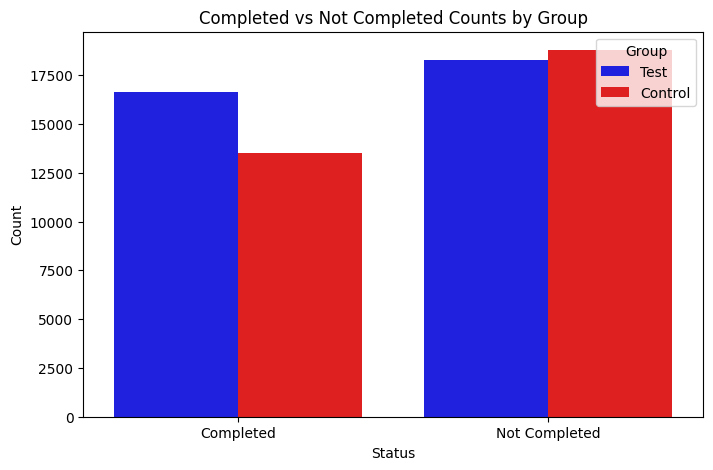

In [25]:
# Plot

# Creating a DataFrame
data = {
    'Group': ['Test', 'Control'],
    'Completed': [16625, 13518],
    'Not Completed': [18258, 18786]
}
df = pd.DataFrame(data)

# Reshaping the DataFrame
df_melted = df.melt(id_vars='Group', var_name='Status', value_name='Count')

# Custom colors for the groups
custom_palette = {'Test': 'blue', 'Control': 'red'}

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(data=df_melted, x='Status', y='Count', hue='Group', palette=custom_palette)
plt.title('Completed vs Not Completed Counts by Group')
plt.xlabel('Status')
plt.ylabel('Count')
plt.legend(title='Group')
plt.show()

## Time spent on each step

Setting hypothesis:

- H0 (Null Hypothesis): The mean time for step 1 in the 'test' group is greater than or equal to the mean time for step 1 in the 'control' group.
- H1 (Alternative Hypothesis): The mean time for step 1 in the 'test' group is less than the mean time for step 1 in the 'control' group.

Significance Level (α): 0.05 

To test this, I will perform a **one-tailed t-test with two samples**.

In [26]:
# this takes into account all the sessions (regardless success/ validity)

# Removing rows with empty values in the 'step_dur' column. In most caseshese empty values occur when it's 
# the last step of the session and there's no next value to compare with
test_step_dur = df_test_rslt[~(df_test_rslt['step_dur'] =='nan')]
control_step_dur = df_control_rslt[~(df_control_rslt['step_dur'] =='nan')]

# Converting step_dur to integers to do numerical operations
test_step_dur['step_dur'] = test_step_dur['step_dur'].astype(int)
control_step_dur['step_dur'] = control_step_dur['step_dur'].astype(int)

# Dropping columns to prepare for the t-test
test_step_dur.drop(columns = ['client_id','date_time','session_id','confirm_cnt',
                              'steps_cnt','steps_back_cnt','sess_dur_to_confirm','validity'], inplace=True)
control_step_dur.drop(columns = ['client_id','date_time','session_id','confirm_cnt',
                                 'steps_cnt','steps_back_cnt','sess_dur_to_confirm','validity'], inplace=True)

# Creating df for each step, for each group, for the t-test
test_step_1_dur = test_step_dur[test_step_dur['step'] == 1]['step_dur']
control_step_1_dur = control_step_dur[control_step_dur['step'] == 1]['step_dur']

test_step_2_dur = test_step_dur[test_step_dur['step'] == 2]['step_dur']
control_step_2_dur = control_step_dur[control_step_dur['step'] == 2]['step_dur']

test_step_3_dur = test_step_dur[test_step_dur['step'] == 3]['step_dur']
control_step_3_dur = control_step_dur[control_step_dur['step'] == 3]['step_dur']

test_step_4_dur = test_step_dur[test_step_dur['step'] == 4]['step_dur']
control_step_4_dur = control_step_dur[control_step_dur['step'] == 4]['step_dur']

In [27]:
# Conducting the t-test for step 1
st.ttest_ind(test_step_1_dur,control_step_1_dur, equal_var=False, alternative='less')

TtestResult(statistic=-9.125572406071743, pvalue=3.6545340722581184e-20, df=73941.9985407766)

With such a small p-value (much less than the significance level of 0.05), we reject the null hypothesis. This suggests that **the mean time for step 1 in the 'test' group is significantly lower than the mean time for step 1 in the 'control' group**.

Also looking at the negative t-statistic value of approximately -9.13, that indicates a significant difference between the two group means, suggesting that the mean duration for step 1 in the 'test' group is substantially lower than that in the 'control' group.

In [28]:
# Conducting the t-test for step 2
st.ttest_ind(test_step_2_dur,control_step_2_dur, equal_var=False, alternative='less')

TtestResult(statistic=19.9933423127373, pvalue=1.0, df=57481.84511687176)

With a p-value of 1.0, we fail to reject the null hypothesis, suggesting that **the mean time for step 2 in the 'test' group is greater than the mean time for step 2 in the 'control' group**.

In [29]:
# Conducting the t-test for step 2 - changing the Alternative Hypothesis
st.ttest_ind(test_step_2_dur,control_step_2_dur, equal_var=False, alternative='greater')

TtestResult(statistic=19.9933423127373, pvalue=6.306508529519198e-89, df=57481.84511687176)

The t-test results with the alternative hypothesis as greater indicate a very low p-value (approximately 6.31e-89), suggesting strong evidence against the null hypothesis. This implies that the mean time for step 2 in the 'test' group is significantly greater than the mean time for step 2 in the 'control' group.

In [30]:
# Conducting the t-test for step 3
st.ttest_ind(test_step_3_dur,control_step_3_dur, equal_var=False, alternative='less')

TtestResult(statistic=-7.100256871384548, pvalue=6.312318724589271e-13, df=48074.17692052184)

The very low p-value suggests strong evidence against the null hypothesis. Therefore, we can conclude that the **mean time for step 3 in the 'test' group is significantly lower than the mean time for step 3 in the 'control' group**.

In [31]:
# Conducting the t-test for step 4
st.ttest_ind(test_step_4_dur,control_step_4_dur, equal_var=False, alternative='less')

TtestResult(statistic=-14.307970828763475, pvalue=1.295957750347291e-46, df=37124.52451675948)

The very low p-value suggests strong evidence against the null hypothesis. Therefore, we can conclude that **the mean time for step 4 in the 'test' group is significantly lower than the mean time for step 4 in the 'control' group**.

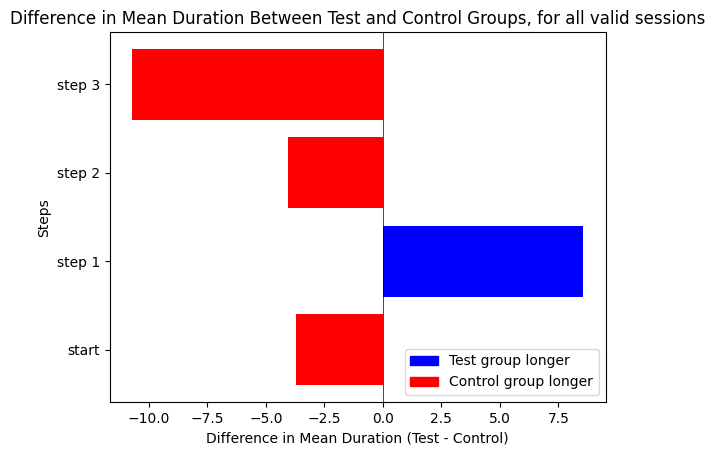

In [32]:
# Plot

# Define the steps
steps = ['start', 'step 1', 'step 2', 'step 3']

# Define the mean durations for each step in the test group
test_means = [test_step_1_dur.mean().round(2), test_step_2_dur.mean().round(2), 
              test_step_3_dur.mean().round(2), test_step_4_dur.mean().round(2)]

# Define the mean durations for each step in the control group
control_means = [control_step_1_dur.mean().round(2), control_step_2_dur.mean().round(2), 
                 control_step_3_dur.mean().round(2), control_step_4_dur.mean().round(2)]


# Calculate the differences between test and control group mean durations
differences = np.array(test_means) - np.array(control_means)

# Set colors for positive and negative differences
colors = ['blue' if diff >= 0 else 'red' for diff in differences]

# Create a diverging bar chart
plt.barh(steps, differences, color=colors)

# Add labels and title
plt.xlabel('Difference in Mean Duration (Test - Control)')
plt.ylabel('Steps')
plt.title('Difference in Mean Duration Between Test and Control Groups, for all valid sessions')

# Add a vertical line at zero
plt.axvline(x=0, color='black', linewidth=0.5)

# Create legend
blue_patch = mpatches.Patch(color='blue', label='Test group longer')
red_patch = mpatches.Patch(color='red', label='Control group longer')
plt.legend(handles=[blue_patch, red_patch], loc='lower right')

# Show plot
plt.show()

## Session duration

In this case:

- **Null Hypothesis (H0):** The mean session duration for the 'test' group is greater than or equal to the mean session duration for the 'control' group.
- **Alternative Hypothesis (H1):** The mean session duration for the 'test' group is less than the mean session duration for the 'control' group.
- **Type of Test:** One-tailed independent samples t-test.

The test is assessing whether there's evidence to suggest that the mean session duration of the 'test' group is significantly less than that of the 'control' group.

In [68]:
# Dropping NaN -> keeping only the rows where sessions reached 'confirm'
df_test_confirm = df_test_rslt.dropna(subset = 'sess_dur_to_confirm')
df_control_confirm = df_control_rslt.dropna(subset = 'sess_dur_to_confirm')

# Select the rows corresponding to the highest 'confirm_cnt' within each group
df_test_confirm_fltrd = df_test_confirm.loc[df_test_confirm.groupby('session_id')['confirm_cnt'].idxmax()]
df_control_confirm_fltrd = df_control_confirm.loc[df_control_confirm.groupby('session_id')['confirm_cnt'].idxmax()]

#df_test_confirm_fltrd['sess_dur_to_confirm'].mean() # 00:04:32.37
#df_control_confirm_fltrd['sess_dur_to_confirm'].mean() # 00:04:41.42

test_confirm_dur = df_test_confirm_fltrd['sess_dur_to_confirm']
control_confirm_dur = df_control_confirm_fltrd['sess_dur_to_confirm']

# transforming the duration to seconds
test_confirm_dur  = test_confirm_dur .dt.total_seconds().apply(lambda x: '{:.0f}'.format(x))
control_confirm_dur  = control_confirm_dur .dt.total_seconds().apply(lambda x: '{:.0f}'.format(x))

test_confirm_dur  = test_confirm_dur [~(test_confirm_dur =='nan')]
control_confirm_dur  = control_confirm_dur [~(control_confirm_dur =='nan')]
# Converting step_dur to integers to do numerical operations
test_confirm_dur = test_confirm_dur.astype(int)
control_confirm_dur = control_confirm_dur.astype(int)

In [34]:
# Conducting the t-test for step 1
st.ttest_ind(test_confirm_dur,control_confirm_dur, equal_var=False, alternative='less')

TtestResult(statistic=-4.568580896563888, pvalue=2.4650278610726664e-06, df=29778.647617239814)

The results of the t-test for step 1 indicate a statistically significant difference in the session duration between the 'test' and 'control' groups. The negative t-statistic value (-4.57) suggests that the mean session duration for the 'test' group is lower than that of the 'control' group. Additionally, the very low p-value (2.47e-06) indicates strong evidence against the null hypothesis, supporting the alternative hypothesis that **the mean session duration for the 'test' group is less than the mean session duration for the 'control' group**.

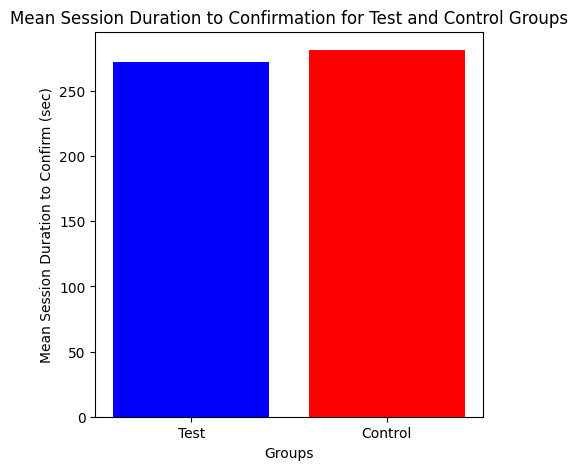

In [35]:
# Plot

# Calculate mean session duration to confirmation for each group
test_mean_dur = test_confirm_dur.mean()
control_mean_dur = control_confirm_dur.mean()

# Data
groups = ['Test', 'Control']
mean_durations = [test_mean_dur, control_mean_dur]

# Plot
plt.figure(figsize=(5, 5))

plt.bar(groups, mean_durations, color=['blue', 'red'])
plt.xlabel('Groups')
plt.ylabel('Mean Session Duration to Confirm (sec)')
plt.title('Mean Session Duration to Confirmation for Test and Control Groups')
plt.show()

#### Checking session duration by age group

In [76]:
# df_test_rslt = df_test_rslt.merge(df_clients[['client_id', 'clnt_age_category']], on='client_id', how='left')
# it is later in the code

test_confirm_dur_age = df_test_confirm_fltrd[['sess_dur_to_confirm','clnt_age_category']]
control_confirm_dur_age = df_control_confirm_fltrd[['sess_dur_to_confirm','clnt_age_category']]

test_confirm_dur_age

,sess_dur_to_confirm,clnt_age_category
12,0 days 00:04:22,55-64 years
25,0 days 00:05:19,35-44 years
32,0 days 00:04:11,55-64 years
51,0 days 00:05:11,65-74 years
56,0 days 00:03:29,55-64 years
...,...,...
176665,0 days 00:02:45,18-24 years
176670,0 days 00:04:12,45-54 years
176675,0 days 00:02:51,65-74 years
176683,0 days 00:01:59,25-34 years


In [79]:
test_confirm_dur_age.groupby('clnt_age_category',observed=False)['sess_dur_to_confirm'].mean()

clnt_age_category
Under 18 year        0 days 00:03:46.333333333
18-24 years          0 days 00:03:50.688650306
25-34 years          0 days 00:03:47.648268680
35-44 years          0 days 00:04:10.180382935
45-54 years          0 days 00:04:57.717245581
55-64 years          0 days 00:05:12.590084643
65-74 years          0 days 00:05:10.081424936
75-84 years             0 days 00:05:41.172000
85 years and older   0 days 00:04:50.765957446
Name: sess_dur_to_confirm, dtype: timedelta64[ns]

In [80]:
control_confirm_dur_age.groupby('clnt_age_category',observed=False)['sess_dur_to_confirm'].mean()

clnt_age_category
Under 18 year        0 days 00:04:08.533333333
18-24 years          0 days 00:03:58.369306930
25-34 years          0 days 00:03:53.157573703
35-44 years          0 days 00:04:22.228841413
45-54 years          0 days 00:05:06.322344322
55-64 years          0 days 00:05:14.300963941
65-74 years          0 days 00:05:31.086824067
75-84 years             0 days 00:05:18.055000
85 years and older   0 days 00:05:18.896551724
Name: sess_dur_to_confirm, dtype: timedelta64[ns]

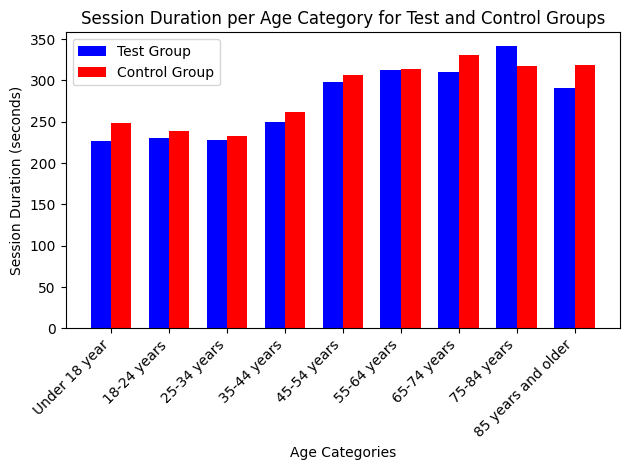

In [83]:
# Plot

# Data
test_means = [226.33, 230.69, 227.65, 250.18, 297.72, 312.59, 310.08, 341.17, 290.77]
control_means = [248.53, 238.37, 233.16, 262.23, 306.32, 314.30, 331.09, 318.06, 318.90]
age_categories = ['Under 18 year', '18-24 years', '25-34 years', '35-44 years', '45-54 years', 
                  '55-64 years', '65-74 years', '75-84 years', '85 years and older']

# Set the width of the bars
bar_width = 0.35

# Set the position of bars on the x-axis
x = np.arange(len(age_categories))

# Create the figure and axes
fig, ax = plt.subplots()

# Plot grouped bars for test group
bars_test = ax.bar(x - bar_width/2, test_means, bar_width, color = 'blue',label='Test Group')

# Plot grouped bars for control group
bars_control = ax.bar(x + bar_width/2, control_means, bar_width, color = 'red',label='Control Group')

# Add labels and title
ax.set_xlabel('Age Categories')
ax.set_ylabel('Session Duration (seconds)')
ax.set_title('Session Duration per Age Category for Test and Control Groups')
ax.set_xticks(x)
ax.set_xticklabels(age_categories, rotation=45, ha='right')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


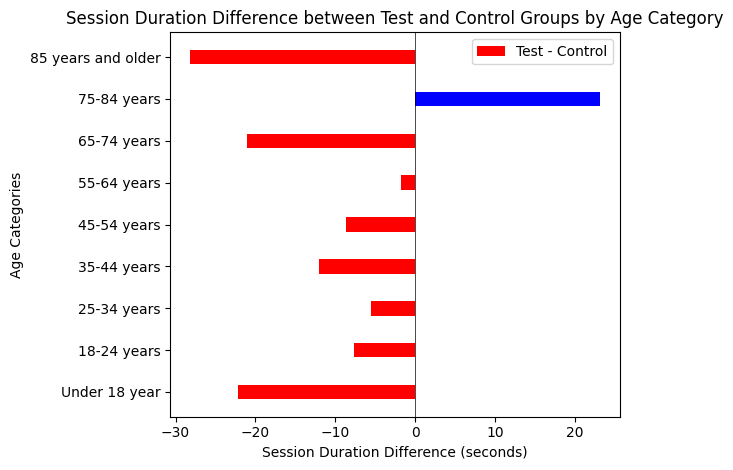

In [87]:
# Plot

# Data
test_means = [226.33, 230.69, 227.65, 250.18, 297.72, 312.59, 310.08, 341.17, 290.77]
control_means = [248.53, 238.37, 233.16, 262.23, 306.32, 314.30, 331.09, 318.06, 318.90]
age_categories = ['Under 18 year', '18-24 years', '25-34 years', '35-44 years', '45-54 years', 
                  '55-64 years', '65-74 years', '75-84 years', '85 years and older']

# Calculate differences
differences = np.array(test_means) - np.array(control_means)

# Set the width of the bars
bar_width = 0.35

# Set the position of bars on the y-axis
y = np.arange(len(age_categories))

# Create the figure and axes
fig, ax = plt.subplots()

# Plot grouped bars for differences
bars_diff = ax.barh(y, differences, bar_width, label='Test - Control', color=['blue' if diff >= 0 else 'red' for diff in differences])

# Add labels and title
ax.set_ylabel('Age Categories')
ax.set_xlabel('Session Duration Difference (seconds)')
ax.set_title('Session Duration Difference between Test and Control Groups by Age Category')
ax.set_yticks(y)
ax.set_yticklabels(age_categories)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


Will not take it into consideration cause the age group 75-84 are a small percentage of the company's customers.

## Total number of steps

In [36]:
# this takes into account the successful and valid sessions
df_test_confirm_fltrd['steps_cnt'].mean().round(2) # 5.93 
df_control_confirm_fltrd['steps_cnt'].mean().round(2) # 5.78

5.78

In [37]:
st.ttest_ind(df_test_confirm_fltrd['steps_cnt'],df_control_confirm_fltrd['steps_cnt'], equal_var=False, alternative='greater')

TtestResult(statistic=7.296205515442493, pvalue=1.516796217048252e-13, df=29875.11165130957)

The t-test results with the alternative hypothesis set to 'greater' indicate a statistic value of approximately 7.30 and a p-value of approximately 1.52e-13. This suggests that there is strong evidence to reject the null hypothesis in favor of the alternative hypothesis. In other words, **there is a significant difference between the mean number of steps completed in the 'Test' group compared to the 'Control' group, with the 'Test' group having a greater mean number of steps**.

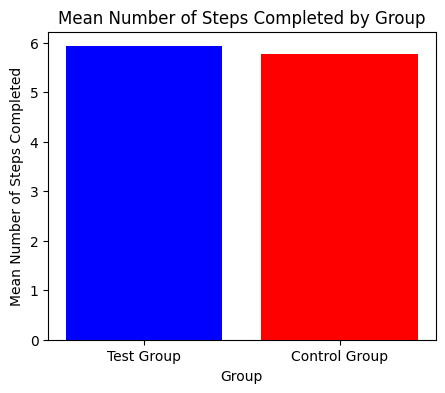

In [38]:
# Plot

# Calculate mean number of steps completed for each group
mean_steps_test = df_test_confirm_fltrd['steps_cnt'].mean()
mean_steps_control = df_control_confirm_fltrd['steps_cnt'].mean()

# Plot
plt.figure(figsize=(5, 4))
plt.bar(['Test Group', 'Control Group'], [mean_steps_test, mean_steps_control], color=['blue', 'red'])
plt.xlabel('Group')
plt.ylabel('Mean Number of Steps Completed')
plt.title('Mean Number of Steps Completed by Group')
plt.show()


In [39]:
test_total_steps = df_test_confirm_fltrd['steps_cnt'].sum() # 98532
control_total_steps = df_control_confirm_fltrd['steps_cnt'].sum() # 78146

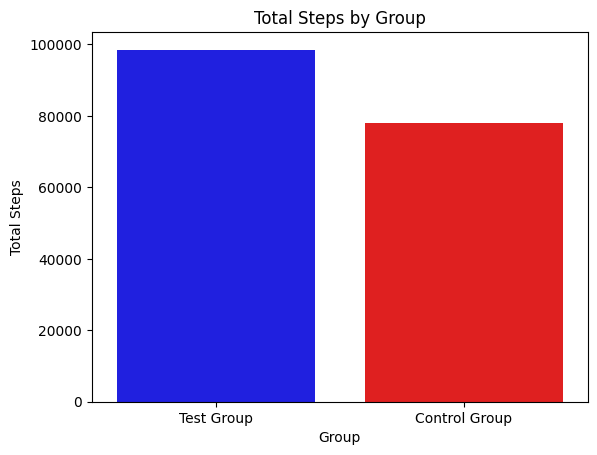

In [40]:
# Plot

# Data
data_total_steps = {
    'Group': ['Test Group', 'Control Group'],
    'Total Steps': [98532, 78146]
}

# Create DataFrame
df_total_steps = pd.DataFrame(data_total_steps)

# Set the Group column as the index
df_total_steps.set_index('Group', inplace=True)

# Define custom palette
custom_palette = {'Test Group': 'blue', 'Control Group': 'red'}

# Plot
sns.barplot(x=df_total_steps.index, y='Total Steps', data=df_total_steps, hue =df_total_steps.index, palette=custom_palette)
plt.xlabel('Group')
plt.ylabel('Total Steps')
plt.title('Total Steps by Group')
plt.show()


#### Mean steps by age group

In [92]:
test_confirm_dur_age = df_test_confirm_fltrd[['steps_cnt','clnt_age_category']]
test_confirm_dur_age.groupby('clnt_age_category', observed=False)['steps_cnt'].mean().round(4)

clnt_age_category
Under 18 year         6.0513
18-24 years           5.8788
25-34 years           5.8120
35-44 years           5.8257
45-54 years           5.9250
55-64 years           6.0831
65-74 years           6.0655
75-84 years           6.1840
85 years and older    5.9574
Name: steps_cnt, dtype: float64

In [93]:
control_confirm_dur_age = df_control_confirm_fltrd[['steps_cnt','clnt_age_category']]
control_confirm_dur_age.groupby('clnt_age_category', observed=False)['steps_cnt'].mean().round(4)

clnt_age_category
Under 18 year         5.6889
18-24 years           5.9376
25-34 years           5.7364
35-44 years           5.6865
45-54 years           5.7897
55-64 years           5.7922
65-74 years           5.8888
75-84 years           5.6700
85 years and older    6.4828
Name: steps_cnt, dtype: float64

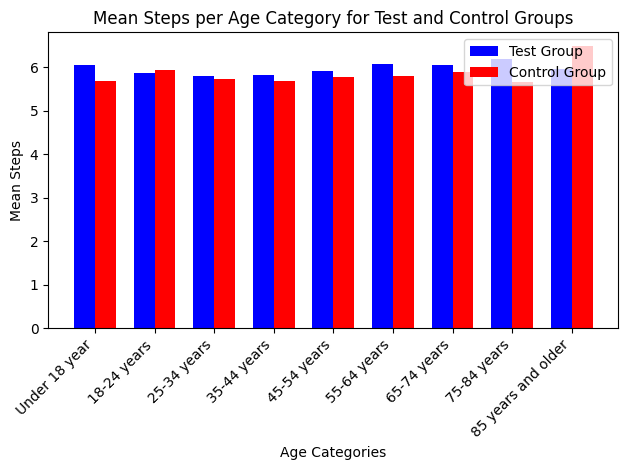

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# Data for test group
test_means = [6.0513, 5.8788, 5.8120, 5.8257, 5.9250, 6.0831, 6.0655, 6.1840, 5.9574]

# Data for control group
control_means = [5.6889, 5.9376, 5.7364, 5.6865, 5.7897, 5.7922, 5.8888, 5.6700, 6.4828]

# Age categories
age_categories = ['Under 18 year', '18-24 years', '25-34 years', '35-44 years', '45-54 years', 
                  '55-64 years', '65-74 years', '75-84 years', '85 years and older']

# Set the width of the bars
bar_width = 0.35

# Set the position of bars on the x-axis
x = np.arange(len(age_categories))

# Create the figure and axes
fig, ax = plt.subplots()

# Plot grouped bars for test group
bars_test = ax.bar(x - bar_width/2, test_means, bar_width,color = 'blue',label='Test Group')

# Plot grouped bars for control group
bars_control = ax.bar(x + bar_width/2, control_means, bar_width, color = 'red', label='Control Group')

# Add labels and title
ax.set_xlabel('Age Categories')
ax.set_ylabel('Mean Steps')
ax.set_title('Mean Steps per Age Category for Test and Control Groups')
ax.set_xticks(x)
ax.set_xticklabels(age_categories, rotation=45, ha='right')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


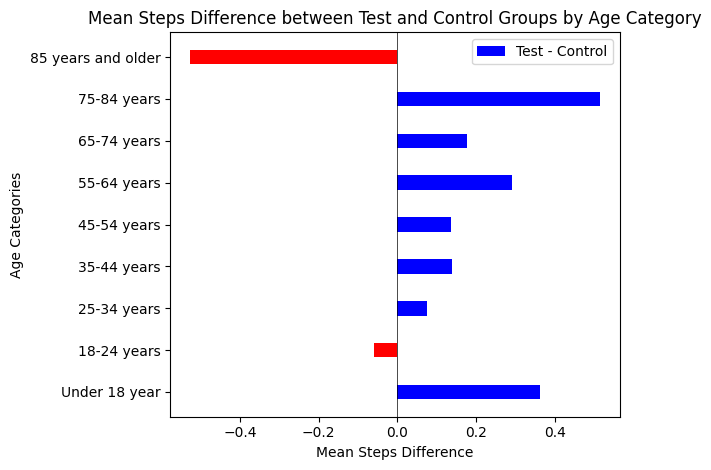

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# Data for test group
test_means = [6.0513, 5.8788, 5.8120, 5.8257, 5.9250, 6.0831, 6.0655, 6.1840, 5.9574]

# Data for control group
control_means = [5.6889, 5.9376, 5.7364, 5.6865, 5.7897, 5.7922, 5.8888, 5.6700, 6.4828]

# Age categories
age_categories = ['Under 18 year', '18-24 years', '25-34 years', '35-44 years', '45-54 years', 
                  '55-64 years', '65-74 years', '75-84 years', '85 years and older']

# Calculate differences
differences = np.array(test_means) - np.array(control_means)

# Set the width of the bars
bar_width = 0.35

# Set the position of bars on the y-axis
y = np.arange(len(age_categories))

# Create the figure and axes
fig, ax = plt.subplots()

# Plot grouped bars for differences
bars_diff = ax.barh(y, differences, bar_width, label='Test - Control', color=['blue' if diff >= 0 else 'red' for diff in differences])

# Add labels and title
ax.set_ylabel('Age Categories')
ax.set_xlabel('Mean Steps Difference')
ax.set_title('Mean Steps Difference between Test and Control Groups by Age Category')
ax.set_yticks(y)
ax.set_yticklabels(age_categories)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


## Error rates

#### Multiple confirms

In [41]:
df_test_confirm_fltrd['confirm_cnt'].mean().round(2) # 1.11  <---
df_control_confirm_fltrd['confirm_cnt'].mean().round(2) # 1.05

# because 'confirm_cnt' counts also the first confirm, to find the extra confirm, I need to subtract
test_extra_confirm = df_test_confirm_fltrd['confirm_cnt'].sum() - test_confirm # 1843
control_extra_confirm = df_control_confirm_fltrd['confirm_cnt'].sum() - control_confirm # 695

# Extra confirm rate, percentage to successfull sessions (with 'confirm')
# I choose the successful sessions for this percentage because the steps back are measured from the successfull sessions
test_extra_confirm_rateper_confirm = round(test_extra_confirm *100 / test_confirm,2) # 11.09
control_extra_confirm_rate_per_confirm = round(control_extra_confirm *100 / control_confirm,2) # 5.14

In [42]:
st.ttest_ind(df_test_confirm_fltrd['confirm_cnt'],df_control_confirm_fltrd['confirm_cnt'], equal_var=False, alternative='greater')

TtestResult(statistic=14.099454569474894, pvalue=2.6608746664540934e-45, df=30136.698999282697)

The very small p-value of approximately 2.66e-45 indicates strong evidence against the null hypothesis. Therefore, we reject the null hypothesis and conclude that **the mean confirmed count in the test group is significantly greater than in the control group**.

#### Steps back

In [43]:
# this takes into account the successful and valid sessions
df_test_confirm_fltrd['steps_back_cnt'].mean().round(2) # 0.32  <---
df_control_confirm_fltrd['steps_back_cnt'].mean().round(2) # 0.3

df_test_confirm_fltrd['steps_back_cnt'].sum() # 5318
df_control_confirm_fltrd['steps_back_cnt'].sum() # 3996

3996

In [44]:
st.ttest_ind(df_test_confirm_fltrd['steps_back_cnt'],df_control_confirm_fltrd['steps_back_cnt'], equal_var=False, alternative='greater')

TtestResult(statistic=2.574463965325324, pvalue=0.005022176578119216, df=29693.35130005687)

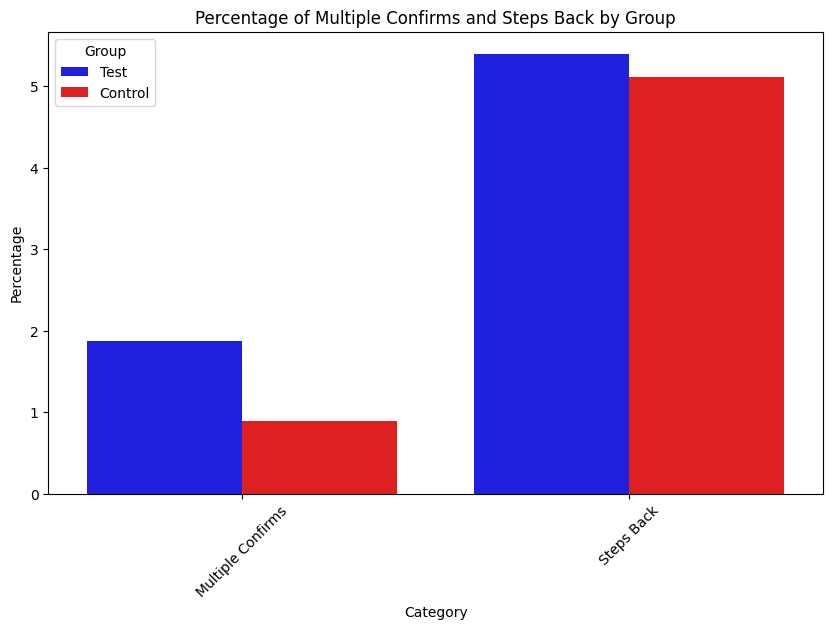

In [45]:
# Plot

test_total_steps = 98532
control_total_steps = 78146
test_extra_confirm = 1843
control_extra_confirm = 695
test_steps_back = df_test_confirm_fltrd['steps_back_cnt'].sum()
control_steps_back = df_control_confirm_fltrd['steps_back_cnt'].sum()

# Calculate percentages
test_confirm_percentage = test_extra_confirm / test_total_steps * 100
control_confirm_percentage = control_extra_confirm / control_total_steps * 100
test_steps_back_percentage = test_steps_back / test_total_steps * 100
control_steps_back_percentage = control_steps_back / control_total_steps * 100

# Data
data = {
    'Group': ['Test', 'Control'],
    'Multiple Confirms': [test_confirm_percentage, control_confirm_percentage],
    'Steps Back': [test_steps_back_percentage, control_steps_back_percentage]
}
df = pd.DataFrame(data)

# Melt the dataframe
df_melted = pd.melt(df, id_vars='Group', var_name='Category', value_name='Percentage')

custom_palette = {'Test': 'blue', 'Control': 'red'}

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Percentage', hue='Group', data=df_melted, palette=custom_palette)
plt.title('Percentage of Multiple Confirms and Steps Back by Group')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Group')

plt.show()


In [46]:
# is there any specific step that had more steps back? 

In [47]:
# this takes into account all the sessions (regardless success/ validity)

df_test_step_error = test_step_dur.groupby('step')['subtract_step'].agg(lambda x: (x < 0).count()).reset_index().set_index('step')
df_test_step_error.drop(5, axis=0, inplace=True)
df_control_step_error = control_step_dur.groupby('step')['subtract_step'].agg(lambda x: (x < 0).count()).reset_index().set_index('step')
df_control_step_error.drop(5, axis=0, inplace=True)

table_2 = df_test_step_error.join(df_control_step_error, lsuffix='_test', rsuffix='_control')
table_2

,subtract_step_test,subtract_step_control
step,,
1,44862,34704
2,33895,24910
3,27847,22991
4,21035,17591


In [48]:
# Chi-square test
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(table_2)
chi2_statistic, chi2_p_value

(137.05705248046615, 1.629163597957003e-29)

In [49]:
# Computing the association between variables using the "cramer" method
association(table_2, method="cramer")

0.024526776482741177

That value shows weak association.

## Correlation between successful sessions and client age category

In [50]:
# adding the age category column to the result dataframe
df_test_rslt = df_test_rslt.merge(df_clients[['client_id', 'clnt_age_category']], on='client_id', how='left')
df_control_rslt = df_control_rslt.merge(df_clients[['client_id', 'clnt_age_category']], on='client_id', how='left')

In [51]:
# Total number of sessions per group
test_sessions = df_test_rslt['session_id'].nunique() # 34883 sessions in total
control_sessions = df_control_rslt['session_id'].nunique() # 32304 sessions in total
# Total number of sessions that reached confirm
test_confirm = df_test_rslt[df_test_rslt['confirm_cnt'] == 1]['session_id'].nunique() # 16654 confirmed
control_confirm = df_control_rslt[df_control_rslt['confirm_cnt'] == 1]['session_id'].nunique() # 13534 confirmed

In [52]:
# Making a dataframe for the crosstab
test_for_crosstab = df_test_rslt[df_test_rslt['confirm_cnt'] == 1]
test_for_crosstab = test_for_crosstab.dropna(subset = 'sess_dur_to_confirm')

control_for_crosstab = df_control_rslt[df_control_rslt['confirm_cnt'] == 1]
control_for_crosstab = control_for_crosstab.dropna(subset = 'sess_dur_to_confirm')

In [53]:
# keeping the first line of each session to count the total sessions
test_for_crosstab_ttl_sess = df_test_rslt[df_test_rslt['steps_cnt'] == 1]
control_for_crosstab_ttl_sess = df_control_rslt[df_control_rslt['steps_cnt'] == 1]

In [54]:
# Grouping test data by age category and calculating the counts of completed and not completed sessions
crosstab_result = pd.crosstab(test_for_crosstab['clnt_age_category'], columns='test_sess_cnt')
crosstab_result_temp = pd.crosstab(control_for_crosstab['clnt_age_category'], columns='control_sess_cnt')
crosstab_result = pd.concat([crosstab_result, crosstab_result_temp], axis=1)

total_sessions_test = pd.crosstab(test_for_crosstab_ttl_sess['clnt_age_category'], columns='total_sessions')
total_sessions_control = pd.crosstab(control_for_crosstab_ttl_sess['clnt_age_category'], columns='total_sessions')

crosstab_result['test_notconfirmed_sess_cnt'] = total_sessions_test['total_sessions'] - crosstab_result['test_sess_cnt']
crosstab_result['control_notconfirmed_sess_cnt'] = total_sessions_control['total_sessions'] - crosstab_result['control_sess_cnt']

crosstab_result = crosstab_result[['test_sess_cnt','test_notconfirmed_sess_cnt','control_sess_cnt','control_notconfirmed_sess_cnt']]
crosstab_result

col_0,test_sess_cnt,test_notconfirmed_sess_cnt,control_sess_cnt,control_notconfirmed_sess_cnt
clnt_age_category,,,,
Under 18 year,39,43,45,45
18-24 years,1304,1166,1010,1193
25-34 years,3841,3094,2951,3220
35-44 years,2977,2694,2434,2820
45-54 years,3282,3897,2730,3739
55-64 years,3308,4788,2801,4941
65-74 years,1572,2932,1313,3075
75-84 years,250,750,200,781
85 years and older,47,78,29,129


In [55]:
# do the chi2 for test/ control seperately

In [56]:
# Chi-square test for 'MSZoning' and 'SaleCondition'
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result[['test_sess_cnt','test_notconfirmed_sess_cnt']])
chi2_statistic, chi2_p_value

(878.6212882495936, 2.3064521445922129e-184)

From the chi-squared test, given the very small p-value, much smaller than a typical significance level of 0.05, it indicates we can reject the null hypothesis. That means that there is an association (or dependence) between the categorical variables of the contingency table.

In [57]:
# Computing the association between variables in 'crosstab_result' using the "cramer" method
association(crosstab_result[['test_sess_cnt','test_notconfirmed_sess_cnt']], method="cramer")

0.15609031473047624

The value from the Cramer's V test suggests a very weak association.

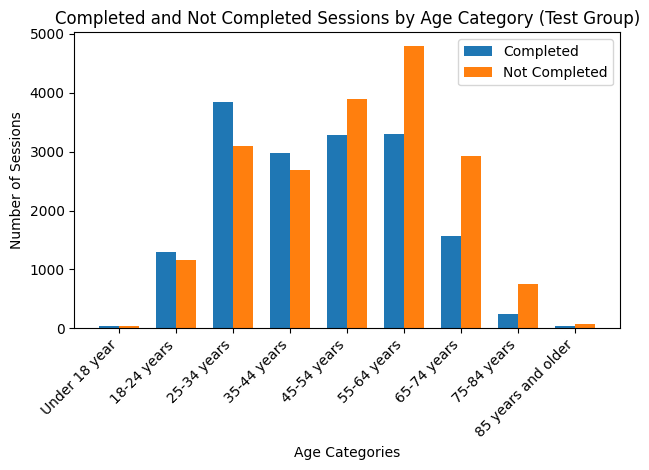

In [58]:
# Plot

# Selecting only the columns for the test group
test_group = crosstab_result[['test_sess_cnt', 'test_notconfirmed_sess_cnt']]

# Extracting age categories
age_categories = test_group.index

# Extracting completed and not completed session counts
completed_sessions = test_group['test_sess_cnt']
not_completed_sessions = test_group['test_notconfirmed_sess_cnt']

# Creating the figure and axes
fig, ax = plt.subplots()

# Width of the bars
bar_width = 0.35

# Position of bars on x-axis
x = range(len(age_categories))

# Plotting completed sessions
completed_bars = ax.bar(x, completed_sessions, width=bar_width, label='Completed')

# Plotting not completed sessions
not_completed_bars = ax.bar([i + bar_width for i in x], not_completed_sessions, width=bar_width, label='Not Completed')

# Adding labels, title, and legend
ax.set_xlabel('Age Categories')
ax.set_ylabel('Number of Sessions')
ax.set_title('Completed and Not Completed Sessions by Age Category (Test Group)')
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(age_categories)
ax.legend()

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()


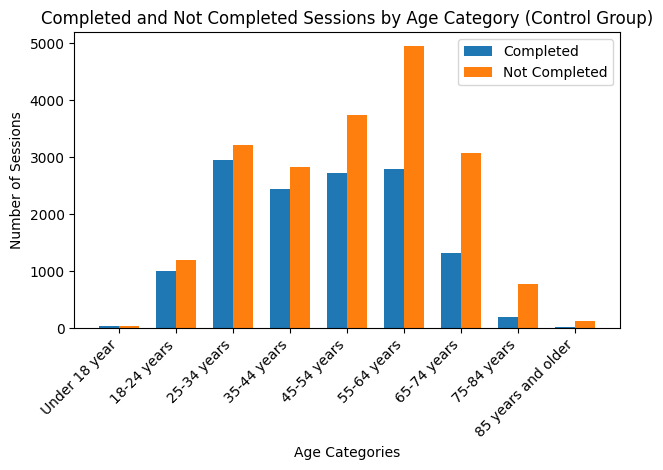

In [59]:
# Plot

# Selecting only the columns for the control group
control_group = crosstab_result[['control_sess_cnt', 'control_notconfirmed_sess_cnt']]

# Extracting completed and not completed session counts
completed_sessions_control = control_group['control_sess_cnt']
not_completed_sessions_control = control_group['control_notconfirmed_sess_cnt']

# Creating the figure and axes
fig, ax = plt.subplots()

# Plotting completed sessions for control group
completed_bars_control = ax.bar(x, completed_sessions_control, width=bar_width, label='Completed')

# Plotting not completed sessions for control group
not_completed_bars_control = ax.bar([i + bar_width for i in x], not_completed_sessions_control, width=bar_width, label='Not Completed')

# Adding labels, title, and legend
ax.set_xlabel('Age Categories')
ax.set_ylabel('Number of Sessions')
ax.set_title('Completed and Not Completed Sessions by Age Category (Control Group)')
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(age_categories)
ax.legend()

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()


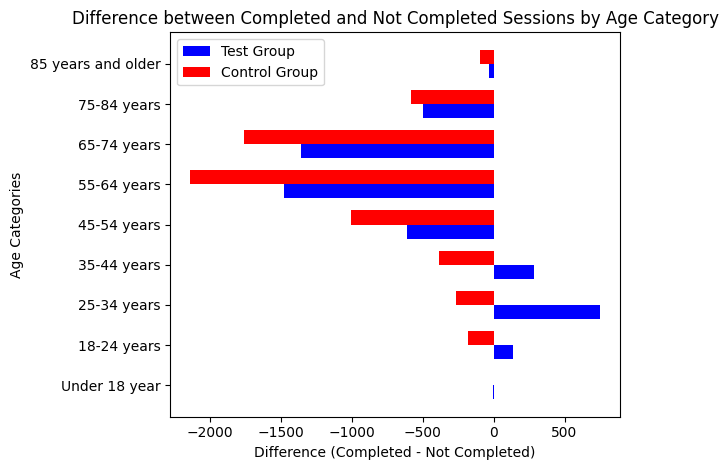

In [60]:
# Plot

# Selecting only the columns for the test and control groups
test_group = crosstab_result[['test_sess_cnt', 'test_notconfirmed_sess_cnt']]
control_group = crosstab_result[['control_sess_cnt', 'control_notconfirmed_sess_cnt']]

# Extracting age categories
age_categories = test_group.index

# Extracting completed and not completed session counts for both groups
completed_sessions_test = test_group['test_sess_cnt']
not_completed_sessions_test = test_group['test_notconfirmed_sess_cnt']
completed_sessions_control = control_group['control_sess_cnt']
not_completed_sessions_control = control_group['control_notconfirmed_sess_cnt']

# Calculating the difference between completed and not completed sessions for both groups
diff_completed_not_completed_test = completed_sessions_test - not_completed_sessions_test
diff_completed_not_completed_control = completed_sessions_control - not_completed_sessions_control

# Creating the figure and axes
fig, ax = plt.subplots()

# Width of the bars
bar_width = 0.35

# Position of bars on y-axis
y = range(len(age_categories))

# Plotting the bars for the test group
bars_test = ax.barh(y, diff_completed_not_completed_test, height=bar_width, color='blue', label='Test Group')

# Plotting the bars for the control group
bars_control = ax.barh([i + bar_width for i in y], diff_completed_not_completed_control, height=bar_width, color='red', label='Control Group')

# Adding labels, title, and legend
ax.set_ylabel('Age Categories')
ax.set_xlabel('Difference (Completed - Not Completed)')
ax.set_title('Difference between Completed and Not Completed Sessions by Age Category')
ax.set_yticks([i + bar_width / 2 for i in y])
ax.set_yticklabels(age_categories)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()
